In [3]:
import pyspark.sql.types as typ
import pyspark.ml.evaluation as ev
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.ml.feature as ft
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pandas.plotting import scatter_matrix
import pandas as pd
import six
from pyspark.sql.functions import abs
import os

In [4]:
# open data file
currentDir = os.getcwd()
lastDir = os.path.abspath(os.path.join(os.getcwd(), ".."))

spark = SparkSession \
    .builder \
    .appName("Machine learning part") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# df = spark.read.csv('file:///Users/Charles/Downloads/p2_vehiclesExport5-5.csv', header = True)
df = spark.read.csv('file://'+ lastDir + '/data/Dataset_vehicles.csv', header = True)

In [5]:
# select the columns we want for the model
cols = ['price','year','manufacturer','model','odometer']
df = df.select(*cols)

In [6]:
# drop null values and change string data type to double type
df = df.na.drop()
df = df.withColumn("price", df["price"].cast(DoubleType()))
df = df.withColumn("year", df["year"].cast(DoubleType()))
df = df.withColumn("odometer", df["odometer"].cast(DoubleType()))

In [7]:
# modify data by subtracting 1900 from year and divide odometer by 5000
df = df.withColumn("year", df['year']-1900)
df = df.withColumn("odometer", df['odometer']/5000)

In [8]:
df.show()

+-------+-----+------------+--------------+--------+
|  price| year|manufacturer|         model|odometer|
+-------+-----+------------+--------------+--------+
|10299.0|112.0|       acura|            tl| 18.0372|
| 9500.0|111.0|      jaguar|            xf|    17.0|
| 3995.0|104.0|       honda|       element| 42.5052|
|12995.0|115.0|         kia|      sportage| 17.0254|
|10995.0|114.0|   chevrolet|      traverse| 22.4766|
| 8995.0|111.0|         bmw|          528i| 24.8892|
| 3995.0|107.0|      toyota|        solara| 37.0246|
| 8995.0|105.0|      toyota|        tacoma|  36.204|
| 7995.0|108.0|      nissan|      frontier| 32.4428|
|11995.0|114.0|  volkswagen|        beetle| 15.4236|
| 5495.0|108.0|        ford|          edge| 27.9808|
| 7995.0|110.0|   chevrolet|silverado 1500|   38.81|
| 8990.0|116.0|        ford|         focus| 15.7754|
|12995.0|109.0|         gmc|         yukon| 29.2706|
|12995.0|109.0|         gmc|         yukon| 29.2706|
| 7995.0|111.0|      subaru|       outback|  2

In [9]:
# encode manufacturer and model by StringIndexer
encoder1 = ft.StringIndexer(inputCol='manufacturer', outputCol='manufacturer_VEC', handleInvalid="skip")
encoder2 = ft.StringIndexer(inputCol='model', outputCol='model_VEC', handleInvalid="skip")

In [10]:
# prepare the data for machine learning, we need only two columns, one is features and one is price
featuresCreator = ft.VectorAssembler(inputCols=['year', 'odometer', encoder1.getOutputCol(), encoder2.getOutputCol()], outputCol='features', handleInvalid="skip")

In [11]:
# define the feature columns and lable columns for linear regression model
lr = LinearRegression(featuresCol = featuresCreator.getOutputCol(), labelCol='price',maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [12]:
# define the stages for pipeline
pipeline = Pipeline(stages = [encoder1, encoder2, featuresCreator, lr])

In [13]:
# split the training and testing dataset
df_train, df_test = df.randomSplit([0.7,0.3], seed = 123)

In [14]:
# put te training dataset into pipeline
model = pipeline.fit(df_train)

In [15]:
# test_model = model.transform(df_test)
# test_model = test_model.withColumn('prediction',abs(test_model.prediction))
# test_model.select("prediction","price","features").show(1000)

In [16]:
# print the rmse and r2 score
trainingSummary = model.stages[-1].summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 8101.437790
r2: 0.406298


In [17]:
# print the coefficients and intercept
print("Coefficients: " + str(model.stages[-1].coefficients))
print("Intercept: " + str(model.stages[-1].intercept))

Coefficients: [1061.9590213054817,-170.06343888999422,-183.7384343594364,2.705290137623428]
Intercept: -99660.84447854967


In [18]:
# define the export table attributes
data = encoder1.fit(df).transform(df)
data1 = encoder2.fit(data).transform(data)
export1 = data1.select(['manufacturer','manufacturer_VEC'])
export2 = data1.select(['model','model_VEC'])
export1 = export1.toPandas()
export2 = export2.toPandas()
export1 = export1.drop_duplicates()
export2 = export2.drop_duplicates()

In [19]:
# export the tables to csv file to current folder
# export1.to_csv('/Users/Charles/Downloads/manufacturer.csv',index = False, header=True)
# export2.to_csv('/Users/Charles/Downloads/model.csv',index = False, header=True)
export1.to_csv(currentDir+'/manufacturer.csv',index = False, header=True)
export2.to_csv(currentDir+'/model.csv',index = False, header=True)

In [20]:
# show dataframe detail to pandas format
data1.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
price,318280,14768.823058313435,10570.081155062764,1000.0,189899.0
year,318280,111.7256817896192,4.7439065450159505,100.0,121.0
manufacturer,318280,None,None,acura,volvo
model,318280,1642.5209203201114,1019.0962605604752,1 series,zephyr
odometer,318280,19.7144984051778,12.168494143215911,2.0E-4,198.0
manufacturer_VEC,318280,6.307832725901722,7.015206755361739,0.0,33.0
model_VEC,318280,106.63014012818901,135.433409167363,0.0,802.0


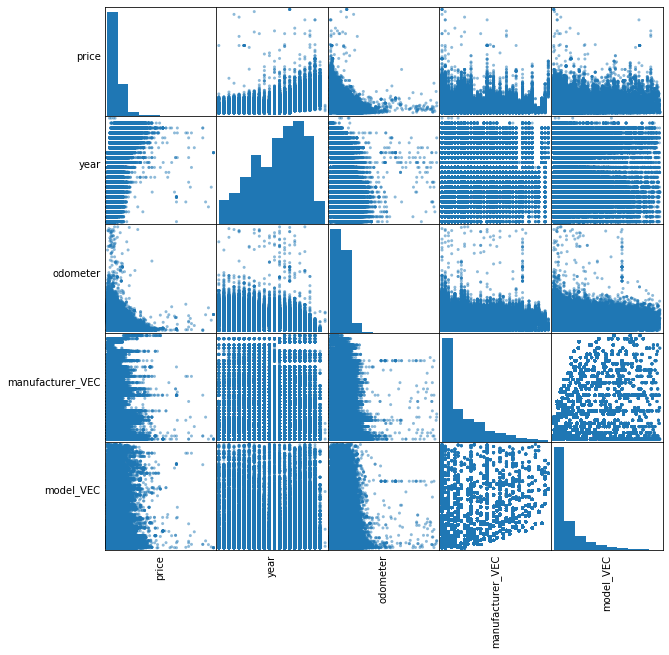

In [21]:
# use scatter matrix to roughly determine if there is a linear correlation between multiple independent variables
numeric_features = [t[0] for t in data1.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = data1.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [22]:
# calculate correlation between independent variables and target variable
for i in data1.columns:
    if not( isinstance(data1.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to price for ", i, data1.stat.corr('price',i))

Correlation to price for  price 1.0
Correlation to price for  year 0.6093636650597247
Correlation to price for  odometer -0.5032801263311916
Correlation to price for  manufacturer_VEC -0.13109459519476474
Correlation to price for  model_VEC -0.05760861258904575
